In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# import
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pprint import pprint
from zen_garden.postprocess.results import Results
from pathlib import Path
from os import chdir

# set path
path = Path('/Users/davidbertschinger/Documents/GitHub/ZEN-garden/notebooks')
chdir(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# define import path begining
path_import = Path("../data/outputs/04_CCTS_WTE_Cement_04_n1_adjusted_scenario_")

# define export path
path_export = Path("../data/04_CCTS_WTE_Cement_04_n1_adjusted_scenarios")

In [23]:
failure_rates = ["failure_rate_0_9", "failure_rate_0_9_capture", "failure_rate_1_0", "failure_rate_1_0_capture", "failure_rate_1_1", "failure_rate_1_1_capture", "failure_rate_1_2", "failure_rate_1_2_capture", "failure_rate_3", "failure_rate_3_capture"]

In [24]:
result_emission_max = Results("../data/outputs/04_CCTS_WTE_Cement_00_emissions")
print(result_emission_max.get_df('carbon_emissions_annual'))

year
0    4.113650e+06
Name: carbon_emissions_annual, dtype: float64


In [25]:
# Initialize an empty list to store the processed data
table_data = []

# Hard-coded maximum and minimum emissions for baseline calculations
emission_max = 4.113650e+06
emission_min = -1200000
emission_reduction_max = emission_max - emission_min

# Iterate over different failure rates
for failure_rate in failure_rates:
    # Construct the path to the data
    path = str(path_import) + str(failure_rate)
    results = Results(path)
    
    # Sort scenarios prioritizing ones containing 'factor_1_'
    sorted_scenarios = sorted(results.scenarios, key=lambda x: 'factor_1_' not in x)
    for scenario in sorted_scenarios:
        # Skip scenarios with generic placeholder names
        if scenario == 'scenario_':
            continue

        # Get data for flow export, cost, carbon emissions, and emission adjustments for each scenario
        results.get_df('flow_export', scenario=scenario, to_csv='flow_export')
        flow_export = pd.read_csv('flow_export.csv', index_col=False)

        states = flow_export['failure_states'].unique()
        co2_stored_data = flow_export[flow_export['carrier'] == "co2_stored"]

        # Extract the adjustment factor from the scenario name
        adjustment_factor_str = scenario.split('_adjustment_factor_')[1]
        adjustment_factor = float(adjustment_factor_str.split('_p00_000')[0])
        
        # Get cost and emission data
        results.get_df("cost_total", scenario=scenario, to_csv="cost")
        cost_df = pd.read_csv('cost.csv', index_col=False)
        results.get_df("carbon_emissions_annual", scenario=scenario, to_csv="carbon_emissions_annual")
        emission_df = pd.read_csv('carbon_emissions_annual.csv', index_col=False)
        
        # Emission adjustment data (if applicable)
        results.get_df("carbon_emissions_annual_limit_adjustment", scenario=scenario, to_csv="emission_adjustment")
        emission_adjustment_df = pd.read_csv('emission_adjustment.csv', index_col=False)

        # Process data for each year within the scenario
        for year in cost_df['year'].unique():
            cost_row = cost_df[cost_df['year'] == year].iloc[0]
            cost_value = cost_row['cost_total']
            emission_row = emission_df[emission_df['year'] == year].iloc[0]
            emission_value = emission_row['carbon_emissions_annual']

            # Calculate CO2 stored and not stored
            co2_stored_year = co2_stored_data[co2_stored_data['time_operation'] == year]
            co2_stored_no_failure = co2_stored_year[co2_stored_year['failure_states'] == "no_failure_technology: no_failure_location"].sum()['flow_export'] * 8760
            co2_not_stored = len(states) * co2_stored_no_failure - co2_stored_year['flow_export'].sum() * 8760
            co2_stored_final = co2_stored_no_failure - co2_not_stored
            
            # Initial minimum cost and stored CO2 values for scenarios without 'capture'
            if adjustment_factor == 1 and 'capture' not in failure_rate:
                min_cost_no_capture = cost_value
                min_co2_stored_no_capture = co2_stored_final
            
            # Calculate emission reductions and efficiency
            emission_reduction = emission_max - emission_value
            system_emissions = co2_stored_final - emission_reduction
            system_emissions_efficiency = emission_reduction / co2_stored_final * 100
            
            # Percentage change in emission reduction
            emission_reduction_change = ((emission_max - emission_value) / emission_reduction_max) * 100
            
            # Cost per CO2 stored and comparison ratios
            cost_per_co2_stored = cost_value / co2_stored_final
            ratio_cost_resilient_cost_non_resilient = cost_per_co2_stored / (min_cost_no_capture / min_co2_stored_no_capture) * 100 - 100

            # Resilience factor
            R = 1 - adjustment_factor

            # Collecting data into the table_data list
            table_data.append({
                'failure_rate': failure_rate,
                'adjustment_factor': adjustment_factor,
                'R': R,
                'year': year,
                'cost [mEUR]': cost_value / (1000000),
                'co2_stored': co2_stored_final,
                'co2_not_stored': co2_not_stored,
                'emission': emission_value,
                'emission_reduction': emission_reduction / (1000000),
                'system_emissions': system_emissions,
                'system_emissions_efficiency': system_emissions_efficiency,
                'emission_reduction_change': emission_reduction_change,
                'cost_per_co2_stored': cost_per_co2_stored,
                'ratio_cost_resilient_cost_non_resilient': ratio_cost_resilient_cost_non_resilient
            })

df = pd.DataFrame(table_data)
df.to_csv('tables/case_study_data')
df

,failure_rate,adjustment_factor,R,year,cost [mEUR],co2_stored,co2_not_stored,emission,emission_reduction,system_emissions,system_emissions_efficiency,emission_reduction_change,cost_per_co2_stored,ratio_cost_resilient_cost_non_resilient
0,failure_rate_0_9,1.0,0.0,0,704.936199,5.437431e+06,55814.946375,-1146958.000,5.260608,176823.349788,96.748035,99.001778,129.645076,0.000000
1,failure_rate_0_9,0.9,0.1,0,705.510835,5.442982e+06,50264.239956,-1152262.200,5.265912,177069.856207,96.746823,99.101601,129.618438,-0.020546
2,failure_rate_0_9,0.8,0.2,0,706.086501,5.448532e+06,44714.405393,-1157566.400,5.271216,177315.490770,96.745628,99.201423,129.592065,-0.040889
3,failure_rate_0_9,0.7,0.3,0,707.131727,5.454153e+06,39093.239315,-1162870.600,5.276521,177632.456848,96.743171,99.301245,129.650144,0.003909
4,failure_rate_0_9,0.6,0.4,0,708.236635,5.459783e+06,33463.375342,-1168174.800,5.281825,177958.120821,96.740564,99.401067,129.718827,0.056887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,failure_rate_3_capture,0.4,0.6,0,706.749931,5.421463e+06,71783.291787,-1129276.364,5.242926,178536.640375,96.706855,98.669020,130.361478,0.000022
106,failure_rate_3_capture,0.3,0.7,0,707.825144,5.439517e+06,53729.455494,-1146957.273,5.260607,178909.567669,96.710929,99.001765,130.126474,-0.180249
107,failure_rate_3_capture,0.2,0.8,0,709.680006,5.457687e+06,35559.767778,-1164638.182,5.278288,179398.346385,96.712923,99.334510,130.033120,-0.251861
108,failure_rate_3_capture,0.1,0.9,0,712.460878,5.475988e+06,17258.297590,-1182319.091,5.295969,180018.907573,96.712577,99.667255,130.106362,-0.195677


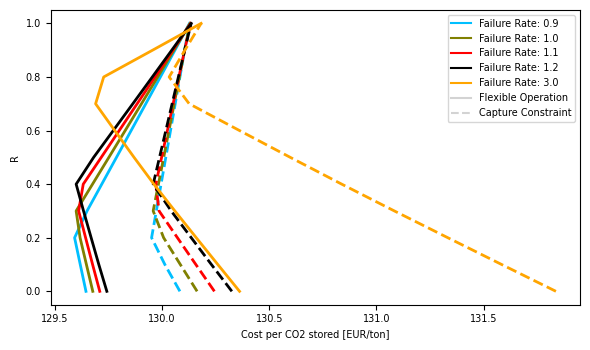

/Users/davidbertschinger/anaconda3/envs/zen-garden-linopy/lib/python3.11/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(



In [26]:
plt.figure(figsize=(6, 3.6), facecolor='white')
import matplotlib.lines as mlines
import matplotlib as mpl

import numpy as np

# Define a basic color palette for the failure rates
color_palette = {
    "failure_rate_0_9": "deepskyblue",
    "failure_rate_1_0": "olive",
    "failure_rate_1_1": "red",
    "failure_rate_1_2": "black",
    "failure_rate_3": "orange",
}

# Define a dash style for capture rates
dash_styles = {
    "capture": (5, 5),  # Dashed line: 5 pixels on, 5 off
    "non_capture": (0, ())  # Solid line for non-capture rates
}

custom_lines = []

# List of failure rates to be removed
remove = []
# Get unique failure rates to plot them as different lines
unique_failure_rates = df['failure_rate'].unique()
# Remove specified failure rates from the unique_failure_rates
filtered_failure_rates = [rate for rate in unique_failure_rates if rate not in remove]

# Plot each failure rate as a separate line
for failure_rate in filtered_failure_rates:
    # Filter the data for the current failure rate
    df_filtered = df[df['failure_rate'] == failure_rate]
    # Sort values for a nice line
    df_sorted = df_filtered.sort_values('emission_reduction_change')
    # Determine if this is a capture rate or not
    is_capture = 'capture' in failure_rate
    # Extract the base failure rate for color and label consistency
    base_failure_rate = failure_rate.split('_capture')[0]
    # Plotting the line for this failure rate
    plt.plot(
        df_sorted['cost_per_co2_stored'], 
        df_sorted['R'],
        color=color_palette[base_failure_rate],
        linestyle='--' if is_capture else '-',
        linewidth=2
    )
    
    # Remove the 'failure_rate_' prefix and replace underscores with periods
    formatted_failure_rate = str(base_failure_rate).removeprefix('failure_rate_').replace('_', '.')
    
    # Create a custom legend handler
    custom_line = mlines.Line2D([], [], color=color_palette[base_failure_rate], linestyle='--' if is_capture else '-',         label=f'Failure Rate: {formatted_failure_rate}' + (" - capture nominal" if "capture" in failure_rate else ""), linewidth=2
)
    # Add the custom_line to a list for the legend
    custom_lines.append(custom_line)


# Setting the title and labels
plt.xlabel('Cost per CO2 stored [EUR/ton]', fontsize=7)
plt.ylabel('R', fontsize=7)

# Configure the custom legend
custom_lines = [
    mlines.Line2D([], [], color=color_palette["failure_rate_0_9"], label='Failure Rate: 0.9'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_0"], label='Failure Rate: 1.0'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_1"], label='Failure Rate: 1.1'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_2"], label='Failure Rate: 1.2'),
    mlines.Line2D([], [], color=color_palette["failure_rate_3"], label='Failure Rate: 3.0'),
    mlines.Line2D([], [], linestyle='-', color='lightgray', label='Flexible Operation'),
    mlines.Line2D([], [], linestyle='--', color='lightgray', label='Capture Constraint')
]
plt.legend(handles=custom_lines, fontsize=7, loc='upper right')

plt.tick_params(axis='x', which='both', labelsize=7)
plt.tick_params(axis='y', which='both', labelsize=7)

# Show the plot
plt.tight_layout()
fig1 = plt.gcf()
plt.show()
fig1.savefig(fname="../plots/R_vs_cost_per_tonne.pdf", format='pdf')

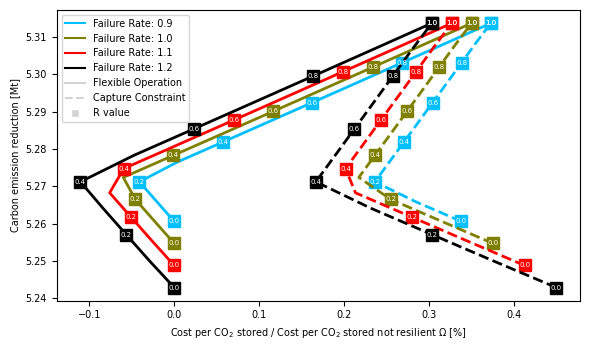

In [27]:
# Initialize the figure with a white background
plt.figure(figsize=(6, 3.6), facecolor='white')

# Define a color palette for the different failure rates
color_palette = {
    "failure_rate_0_9": "deepskyblue",
    "failure_rate_1_0": "olive",
    "failure_rate_1_1": "red",
    "failure_rate_1_2": "black",
}

# Identify failure rates to exclude from the plot
remove = ["failure_rate_3", "failure_rate_3_capture"]

# Get unique failure rates from the data and filter out the ones to remove
unique_failure_rates = df['failure_rate'].unique()
filtered_failure_rates = [rate for rate in unique_failure_rates if rate not in remove]

# Plot each filtered failure rate as a separate line
for failure_rate in filtered_failure_rates:
    df_filtered = df[df['failure_rate'] == failure_rate]
    df_sorted = df_filtered.sort_values('emission_reduction_change')

    is_capture = 'capture' in failure_rate
    base_failure_rate = failure_rate.split('_capture')[0]

    plt.plot(
        df_sorted['ratio_cost_resilient_cost_non_resilient'], 
        df_sorted['emission_reduction'],
        color=color_palette[base_failure_rate],
        linestyle= 'dashed' if is_capture else 'solid',
        linewidth=2
    )

    # Mark adjustment factor points with square markers at intervals
    for count, row in enumerate(df_sorted.iterrows()):
        _, row = row  # unpack the tuple
        if count % 2 == 0:
            plt.plot(
                row['ratio_cost_resilient_cost_non_resilient'], 
                row['emission_reduction'],
                marker='s',
                markersize=8,
                color=color_palette[base_failure_rate],
                linestyle=''
            )
            plt.text(
                row['ratio_cost_resilient_cost_non_resilient'], 
                row['emission_reduction'], 
                str(round(row['R'], 1)),
                color='white', 
                fontsize=5,
                ha='center',
                va='center'
            )

# Set axis labels
plt.xlabel(r'Cost per CO$_2$ stored / Cost per CO$_2$ stored not resilient $\Omega$ [%]', fontsize=7)
plt.ylabel(r'Carbon emission reduction [Mt]', fontsize=7)

# Configure the custom legend
custom_lines = [
    mlines.Line2D([], [], color=color_palette["failure_rate_0_9"], label='Failure Rate: 0.9'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_0"], label='Failure Rate: 1.0'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_1"], label='Failure Rate: 1.1'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_2"], label='Failure Rate: 1.2'),
    mlines.Line2D([], [], linestyle='-', color='lightgray', label='Flexible Operation'),
    mlines.Line2D([], [], linestyle='--', color='lightgray', label='Capture Constraint'),
    mlines.Line2D([], [], marker='s', color='white', markerfacecolor='lightgray', label='R value')
]
plt.legend(handles=custom_lines, fontsize=7, loc='upper left')

# Adjust tick parameters for both axes
plt.tick_params(axis='both', which='both', labelsize=7)

# Display and save the plot
plt.tight_layout()
fig1 = plt.gcf()
plt.show()
fig1.savefig(fname="../plots/Emissions_vs_relative_cost.pdf", format='pdf')

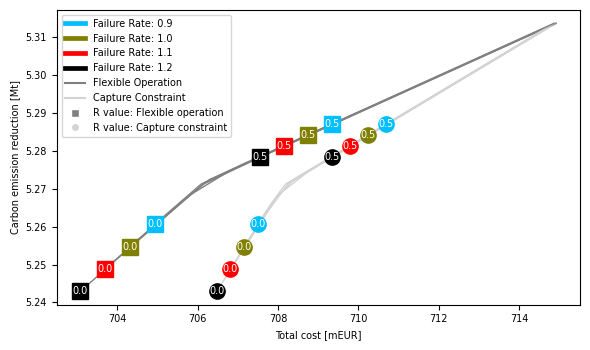

In [29]:
plt.figure(figsize=(6, 3.6), facecolor='white')

# Define a basic color palette for the failure rates
color_palette = {
    "failure_rate_0_9": "deepskyblue",
    "failure_rate_1_0": "olive",
    "failure_rate_1_1": "red",
    "failure_rate_1_2": "black",
    "failure_rate_3": "orange",
}


# Define a dash style for capture rates
dash_styles = {
    "capture": (5, 5),  # Dashed line: 5 pixels on, 5 off
    "non_capture": (0, ())  # Solid line for non-capture rates
}

custom_lines = []

# List of failure rates to be removed
remove = ["failure_rate_3", "failure_rate_3_capture"]
# Get unique failure rates to plot them as different lines
unique_failure_rates = df['failure_rate'].unique()
# Remove specified failure rates from the unique_failure_rates
filtered_failure_rates = [rate for rate in unique_failure_rates if rate not in remove]

# Plot each failure rate as a separate line
for failure_rate in reversed(filtered_failure_rates):
    # Filter the data for the current failure rate
    df_filtered = df[df['failure_rate'] == failure_rate]
    # Sort values for a nice line
    df_sorted = df_filtered.sort_values('emission_reduction')
    # Determine if this is a capture rate or not
    is_capture = 'capture' in failure_rate
    # Extract the base failure rate for color and label consistency
    base_failure_rate = failure_rate.split('_capture')[0]
    # Plotting the line for this failure rate
    plt.plot(
        df_sorted['cost [mEUR]'], 
        df_sorted['emission_reduction'],
        color='lightgrey'if "capture" in failure_rate else 'grey',
        linewidth=1,
        zorder=1,
    )
    

    # Marking the adjustment factor points
    for _, row in df_sorted.iterrows():
        if round(row['R'],1) == 0 or round(row['R'],1) == 0.5:
            
            plt.plot(
                row['cost [mEUR]'], 
                row['emission_reduction'],
                marker='o' if "capture" in failure_rate else 's',
                markersize=11,
                markerfacecolor = color_palette[base_failure_rate],
                markeredgecolor = color_palette[base_failure_rate],
                linestyle = '')
                    
            plt.text(
                row['cost [mEUR]'], 
                row['emission_reduction'], 
                 str(round(row['R'],1)),
                
                color='white', 
                fontsize=7,
                ha= 'center',
                va='center'  # vertical alignment
        )


# Setting the title and labels
plt.xlabel(r'Total cost [mEUR]', fontsize=7)
plt.ylabel(r'Carbon emission reduction [Mt]', fontsize=7)

# Adding the legend
custom_lines = [
    mlines.Line2D([], [], color=color_palette["failure_rate_0_9"], linewidth=3.4, label='Failure Rate: 0.9'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_0"], linewidth=3.4, label='Failure Rate: 1.0'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_1"], linewidth=3.4, label='Failure Rate: 1.1'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_2"], linewidth=3.4, label='Failure Rate: 1.2'),
    mlines.Line2D([], [], linestyle='-', color='grey', label='Flexible Operation'),
    mlines.Line2D([], [], linestyle='-', color='lightgray', label='Capture Constraint'),
    mlines.Line2D([], [], marker='s', color='white', markerfacecolor='grey', label='R value: Flexible operation'),
    mlines.Line2D([], [], marker='o', color='white', markerfacecolor='lightgrey', label='R value: Capture constraint')
]

plt.legend(handles=custom_lines, fontsize=7, loc='upper left')
plt.tick_params(axis='x', which='both', labelsize=7)
plt.tick_params(axis='y', which='both', labelsize=7)

# Show the plot
plt.tight_layout()
fig1 = plt.gcf()
plt.show()
fig1.savefig(fname="../plots/Emission_vs_total_cost.pdf", format='pdf')

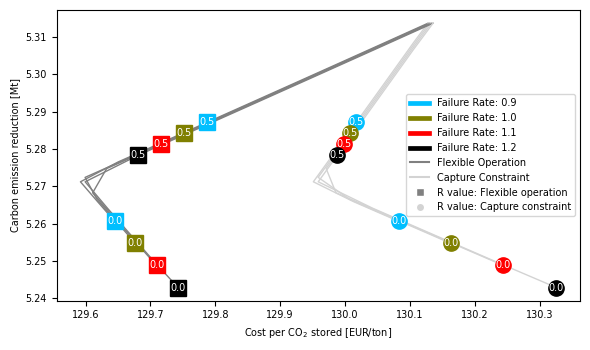

In [30]:
plt.figure(figsize=(6, 3.6), facecolor='white')

# Define a basic color palette for the failure rates
color_palette = {
    "failure_rate_0_9": "deepskyblue",
    "failure_rate_1_0": "olive",
    "failure_rate_1_1": "red",
    "failure_rate_1_2": "black",
    "failure_rate_3": "orange",
}


# Define a dash style for capture rates
dash_styles = {
    "capture": (5, 5),  # Dashed line: 5 pixels on, 5 off
    "non_capture": (0, ())  # Solid line for non-capture rates
}

custom_lines = []

# List of failure rates to be removed
remove = ["failure_rate_3", "failure_rate_3_capture"]
# Get unique failure rates to plot them as different lines
unique_failure_rates = df['failure_rate'].unique()
# Remove specified failure rates from the unique_failure_rates
filtered_failure_rates = [rate for rate in unique_failure_rates if rate not in remove]

# Plot each failure rate as a separate line
for failure_rate in filtered_failure_rates:
    # Filter the data for the current failure rate
    df_filtered = df[df['failure_rate'] == failure_rate]
    # Sort values for a nice line
    df_sorted = df_filtered.sort_values('emission_reduction')
    # Determine if this is a capture rate or not
    is_capture = 'capture' in failure_rate
    # Extract the base failure rate for color and label consistency
    base_failure_rate = failure_rate.split('_capture')[0]
    # Plotting the line for this failure rate
    plt.plot(
        df_sorted['cost_per_co2_stored'], 
        df_sorted['emission_reduction'],
        color='lightgrey'if "capture" in failure_rate else 'grey',
        linewidth=1,
        zorder=1,
    )
    
    # Add the custom_line to a list for the legend
    custom_lines.append(custom_line)

    # Marking the adjustment factor points
    for _, row in df_sorted.iterrows():
        if round(row['R'],1) == 0 or round(row['R'],1) == 0.5:
            
            plt.plot(
                row['cost_per_co2_stored'], 
                row['emission_reduction'],
                marker='o' if "capture" in failure_rate else 's',
                markersize=11,
                markerfacecolor = color_palette[base_failure_rate],
                markeredgecolor = color_palette[base_failure_rate],
                linestyle = '')
                    
            plt.text(
                row['cost_per_co2_stored'], 
                row['emission_reduction'], 
                 str(round(row['R'],1)),
                
                color='white', 
                fontsize=7,
                ha= 'center',
                va='center'  # vertical alignment
        )


# Setting the title and labels
plt.xlabel(r'Cost per CO$_2$ stored [EUR/ton]', fontsize=7)
plt.ylabel(r'Carbon emission reduction [Mt]', fontsize=7)

# Adding the legend
custom_lines = [
    mlines.Line2D([], [], color=color_palette["failure_rate_0_9"], linewidth=3.4, label='Failure Rate: 0.9'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_0"], linewidth=3.4, label='Failure Rate: 1.0'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_1"], linewidth=3.4, label='Failure Rate: 1.1'),
    mlines.Line2D([], [], color=color_palette["failure_rate_1_2"], linewidth=3.4, label='Failure Rate: 1.2'),
    mlines.Line2D([], [], linestyle='-', color='grey', label='Flexible Operation'),
    mlines.Line2D([], [], linestyle='-', color='lightgray', label='Capture Constraint'),
    mlines.Line2D([], [], marker='s', color='white', markerfacecolor='grey', label='R value: Flexible operation'),
    mlines.Line2D([], [], marker='o', color='white', markerfacecolor='lightgrey', label='R value: Capture constraint')
]

plt.legend(handles=custom_lines, fontsize=7, loc='best')
plt.tick_params(axis='x', which='both', labelsize=7)
plt.tick_params(axis='y', which='both', labelsize=7)

# Show the plot
plt.tight_layout()
fig1 = plt.gcf()
plt.show()
fig1.savefig(fname="../plots/Emissions_vs_cost_per_tonne.pdf", format='pdf')